# (실습) 데이터의 군집화 방법론

## 실습 개요

1) **실습 목적**

이번 실습에서는 데이터로부터 패턴을 파악해 데이터를 여러 개의 집단(cluster)으로 나누는 데이터 군집화에 대해서 실습해봅니다. 대표적인 군집화 방법론인 k-means clustering 알고리즘이 어떻게 동작하는지에 대해서 학습합니다.


2) **수강 목표**

- k-means 군집화 알고리즘을 적용하기 위해 피쳐 값 스케일링 전처리가 필요한 이유를 알고있다.
- 사이킷런 패키지를 활용해 k-means 군집화 알고리즘을 적용할 수 있다.

### 실습 목차
* 1. 실습 데이터셋 준비
  * 1-1. 데이터셋을 불러와 전처리 적용
* 2. k-means 군집화(clustering) 방법론
  * 2-1. k-means 군집화의 단계별 이해
  * 2-2. 사이킷런을 활용한 k-means 군집화
  * 2-3. 랜덤 합성데이터의 군집화


### 환경 설정

- 패키지 설치 및 임포트

In [22]:
# 패키지 불러오기
import numpy as np
import pandas as pd
# k-means clustering 구현을 위한 sklearn 패키지 내 함수 불러오기
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
# 시각화 패키지 불러오기
import matplotlib.pyplot as plt
import plotly.express as px

###  데이터셋 개요

* 데이터셋: iris(붓꽃) 데이터
* 데이터셋 개요: 붓꽃의 꽃잎 길이와 너비, 꽃받침의 길이, 너비까지 총 4개 변수를 활용해 붓꽃의 총
3개 세부종 중 어느것에 속하는지를 분류하는 데이터셋입니다. 총 150개의 샘플을 포함하고있습니다.
* 데이터셋 저작권 : CC BY 4.0
* [데이터셋 출처 - UCI](https://archive.ics.uci.edu/dataset/53/iris)

## 1. 실습 데이터셋 준비
```
💡 목차 개요 : 실습에 사용할 iris 데이터셋을 불러와 살펴보고, 필요한 전처리 과정을 적용합니다.
```

### 1-1. 데이터셋을 불러와 전처리 적용
> Scikit learn에서 제공하는 `load_iris` 함수를 사용해 실습에 사용할 iris 데이터셋을
불러온 뒤, 데이터셋의 기본적인 정보를 확인해봅니다.



Iris 데이터셋은 총 4개의 피쳐를 포함하고있지만, 이번 분석에서는 시각화의 편의를 위해 앞 2개의 피쳐
(꽃받침 길이와 너비, Sepal length / width)만을 사용하도록 합니다.


#### 👨‍💻 코드 : 데이터셋 불러오기
- 사이킷런 패키지를 활용해 iris 데이터셋 로드
- 분석에 사용할 피쳐 선택

In [23]:
# 데이터 불러오기
iris = datasets.load_iris()

# 인풋, 아웃풋을 X, y변수로 할당
X = iris.data
y = iris.target

# 대략적인 샘플 수, 피쳐 수를 확인
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [24]:
# 분석에 사용할 첫 두개 피쳐만을 선택
X = X[:, :2]

#### 📝 설명: 데이터 전처리

k-means clustering은 분석 과정에서 **거리**의 개념을 사용하는데, 각 피쳐간 변동의 스케일이 다른
경우 문제가 생길 수 있습니다. 예를 들어, 한 변수는 0~1 범위에서 소수점 자리에서만 변동이 있는
변수인데, 다른 변수는 수백, 수천 단위로 매우 큰 변동폭을 보인다면 두 변수를 함께 활용해 거리를 계산하면
전자의 변수가 전혀 고려되지 않아 문제가 생길것입니다.

본 실습에 사용하는 iris 데이터셋은 모든 피쳐가 cm단위로 측정된 길이 값으로, 피쳐 사이에 스케일 차이가
크지 않아 그대로 분석해도 무방하지만, 연습삼아 min-max scaling 방식의 표준화(standardization)
전처리를 적용해보겠습니다.

#### 👨‍💻 코드 : min-max scaling 방식의 전처리 적용
- 사이킷런의 MinMaxScaler 클래스 초기화
- 데이터 X에 transform 적용

In [25]:
# min-max scaling을 이용해 정규화하기
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## 2. k-means 군집화(clustering) 방법론
```
💡 목차 개요 : 실습 데이터셋에 k-means 방식의 군집화를 적용해봅니다.
```

#### 📝 설명: k-means 군집화

k-means clustering은 군집화 방법 중 하나로, k개의 군집을 나눌 때 평균(mean)을 이용하는 방법입니다. 한 집단에 속한 데이터 포인트들 간의 거리가 서로 다른 집단에 속한 데이터 포인트 간의 거리보다 더 가깝도록 집단을 나누어야 합니다. 이때 거리 함수는 L2 norm으로 정의합니다. 따라서 이 알고리즘의 목표는 __각각의 데이터 포인트로부터 가장 가까운 군집의 중심까지 거리의 제곱합의 가중합이 최소가 되도록__ 하는 것입니다. 이 군집의 중심을 잘 찾고 각 데이터 포인트들을 각 군집에 할당하여야 합니다.



### 2-1. k-means 군집화의 단계별 이해

#### 📝 설명: k-means Clustering의 수학적 이해

D차원의 데이터 집합 $\{\mathbf{x}_1,\dots,\mathbf{x}_N\}$을
$K$개의 군집으로 나누는 군집화를 수행한다고 생각해보겠습니다.
여기서 $k$번째 군집의 중심을 $\boldsymbol{\mu}_k$라고 하고,

$i$번째 데이터 $\mathbf{x}_i$가 $k$번째 군집에 할당되었는지를 나타내는 indicator 변수
$r_{ik}$를 이용해 군집이 나뉜 상태를 표시합니다. 이 경우 우리의 목표 함수 (objective function)는
$$J=\sum_{i=1}^N\sum_{k=1}^K r_{ik}\|\mathbf{x}_i-\mathbf{\mu}_k\|^2$$ 로 정의할 수 있습니다. 이는 각 데이터 포인트 $\mathbf{x}_i$가 $k$번째 군집에 할당되면 $k$번째 군집의 중심인 $\boldsymbol{\mu}_k$와의 거리가 다른 어떤 군집중심과의 거리보다도 작아야 한다는 것을 의미합니다.

이제 우리는 $J$를 $r_{ik}$와 $\boldsymbol{\mu}_k$에 대해서 최소화해야 합니다.

- **step 1:** 먼저 $r_{ik}$에 대해서 $J$를 최소화해봅시다. $J$는 $r_{ik}$에 대해서 선형이므로 $\mathbf{x}_i$와의 거리가 최소인 군집의 중심의 경우를 $r_{ik}=1$로 두면 됩니다. 즉, $$r_{ik}=\mathbb{I}\left[k=\arg\min_j\|\mathbf{x}_i-\boldsymbol{\mu}_j\|^2\right].$$

- **step 2:**  step 1에서 구한 $r_{ik}$ 값을 고정하고 $\boldsymbol{\mu}_k$에 대해서 $J$를 최소화해야 합니다. $J$는 $\boldsymbol{\mu}_k$에 대해서 제곱함수이므로 이를 $\boldsymbol{\mu}_k$에 대해서 미분하고 이 값을 0으로 두어 최솟값을 찾을 수 있습니다. 따라서 $$\boldsymbol{\mu}_k=\frac{\sum_{i=1}^N r_{ik}\mathbf{x}_i}{\sum_{i=1}^N r_{ik}.}$$
여기서 $\boldsymbol{\mu}_k$ 식의 분모는 $k$번째 군집에 할당된 데이터 포인트들의 수를 의미하게 됩니다. 따라서 이는 $k$번째 군집에 할당된 모든 데이터 포인트들의 평균으로 해석할 수 있습니다.

- **step 3:**  step 1과 step 2를 반복하여 형성된 군집이 더이상 바뀌지 않을 때까지 수행하여 최적의 군집을 형성합니다. 여기서 새롭게 찾은 군집의 중심에 대해서 각 데이터 포인트 간의 거리를 다시 계산하고 최소화될 수 있는 다른 군집의 중심이 있다면 그것으로 변경되며 이를 반복하는 작업을 포함합니다.



#### 📝 설명: 초기 군집 설정


k-means clustering을 수행하기 전 clustering을 수행할 군집(cluster)의 개수, k를 지정해야
합니다. 여기서는 원래의 데이터셋이 3개 클래스를 분류하기 위한 데이터셋이라는 정보를 알고있으므로, k를 3으로 지정합니다.

#### 👨‍💻 코드 : 초기 군집 중심을 설정하기
- 군집 수 k 설정
- 기존 데이터중 k개를 랜덤으로 골라 초기 군집의 중심 설정
- 설정된 결과를 시각화

In [26]:
# 재현성을 위해 랜덤시드를 고정
np.random.seed(1234)

# 군집화를 수행할 군집 수
n_cluster = 3

# 기존 데이터 중 랜덤으로 선택하여 초기 군집의 중심을 설정
init_idx = np.random.randint(X.shape[0], size=n_cluster)
init_data = X[init_idx, :]

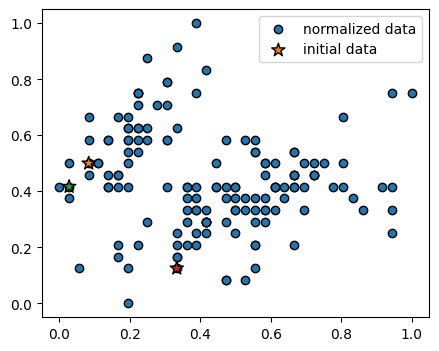

In [27]:
# 정규화된 데이터 시각화
plt.figure(figsize=(5, 4))
plt.scatter(X[:, 0], X[:, 1], c='C0', label='normalized data', edgecolor="k")

# 초기 군집 중심을 별표로 시각화
plt.scatter(init_data[:, 0], init_data[:, 1], edgecolor="k", c=['C1','C2','C3'], label='initial data', marker='*', s=100)
plt.legend()
plt.show()


#### 📝 설명 : 군집 중심을 활용해 초기 데이터를 할당

먼저, 초기 군집으로 데이터를 할당합니다. 첫번째 단계에서는 위에서 설정한 초기 데이터를 군집의 중심으로 두고, 각 데이터 포인트와 중심 간의 거리를 계산하여 더 가까운 중심이 해당하는 군집으로 초기 군집화를 수행합니다.

In [28]:
# 군집화 초기화: 0th iteration
iter = 0

# 군집의 중심을 위에서 설정한 초기 데이터로 정의 (mu_k)
centroid = init_data

# step 1: 각 데이터 포인트에서 각 군집 중심까지의 거리를 계산 후, 가장 가까운 군집중심을 가진 군집으로 할당 (r_ik)
diff = X.reshape(-1, 1, 2) - centroid
distances = np.linalg.norm(diff, 2, axis=-1)
clusters = np.argmin(distances, axis=-1)

In [29]:
# 군집화 결과 시각화 도움 함수
def plot_cluster(X, clusters, centroid, iter=0):
    plt.figure(figsize=(5, 4))
    # 군집화된 데이터
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap=plt.cm.Set1, edgecolor="k", label='data')
    # 군집의 중심 시각화
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='*', s=100, edgecolor="k", c=['C1','C2','C3'], label='centroid')
    plt.title(f'Clustering results (iter={iter})')
    plt.legend()
    plt.show()

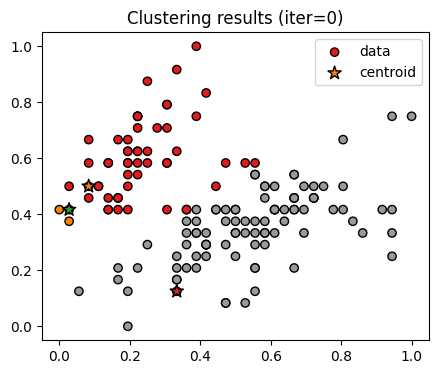

In [30]:
# 군집화 결과 시각화
plot_cluster(X, clusters, centroid, iter)

#### 📝 설명 : 군집화 과정의 반복

군집화 과정을 반복합니다. 위에서 설정된 초기 군집에 대하여 각 군집의 중심을 다시 각 군집에 할당된 데이터들의 평균으로 다시 정의합니다 ($\boldsymbol{\mu}_k$). 이를 기반으로 각 데이터 포인트들과 새로 정의된 군집의 중심과의 거리를 계산하고 더 가까운 군집으로 데이터 포인트를 할당합니다.

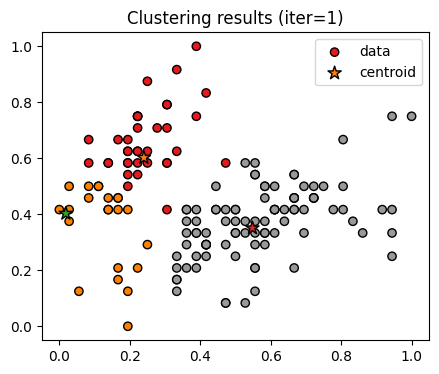

In [31]:
iter += 1  # 다음 iteration

# step2: 군집의 중심을 각 군집에 할당된 데이터들의 평균으로 정의 (mu_k)
clusters = np.array(clusters)
centroid = np.array([
    X[clusters == 0, :].mean(axis=0),
    X[clusters == 1, :].mean(axis=0),
    X[clusters == 2, :].mean(axis=0),
])

# step 1: 각 데이터 포인트에서 각 군집 중심까지의 거리를 계산 후, 가장 가까운 군집중심을 가진 군집으로 할당 (r_ik)
diff = X.reshape(-1, 1, 2) - centroid
distances = np.linalg.norm(diff, 2, axis=-1)
clusters = np.argmin(distances, axis=-1)

# 결과를 시각화
plot_cluster(X, clusters, centroid, iter)

같은 과정을 몇번 더 반복해, 반복횟수에 따른 군집화 결과의 차이를 관찰합니다.

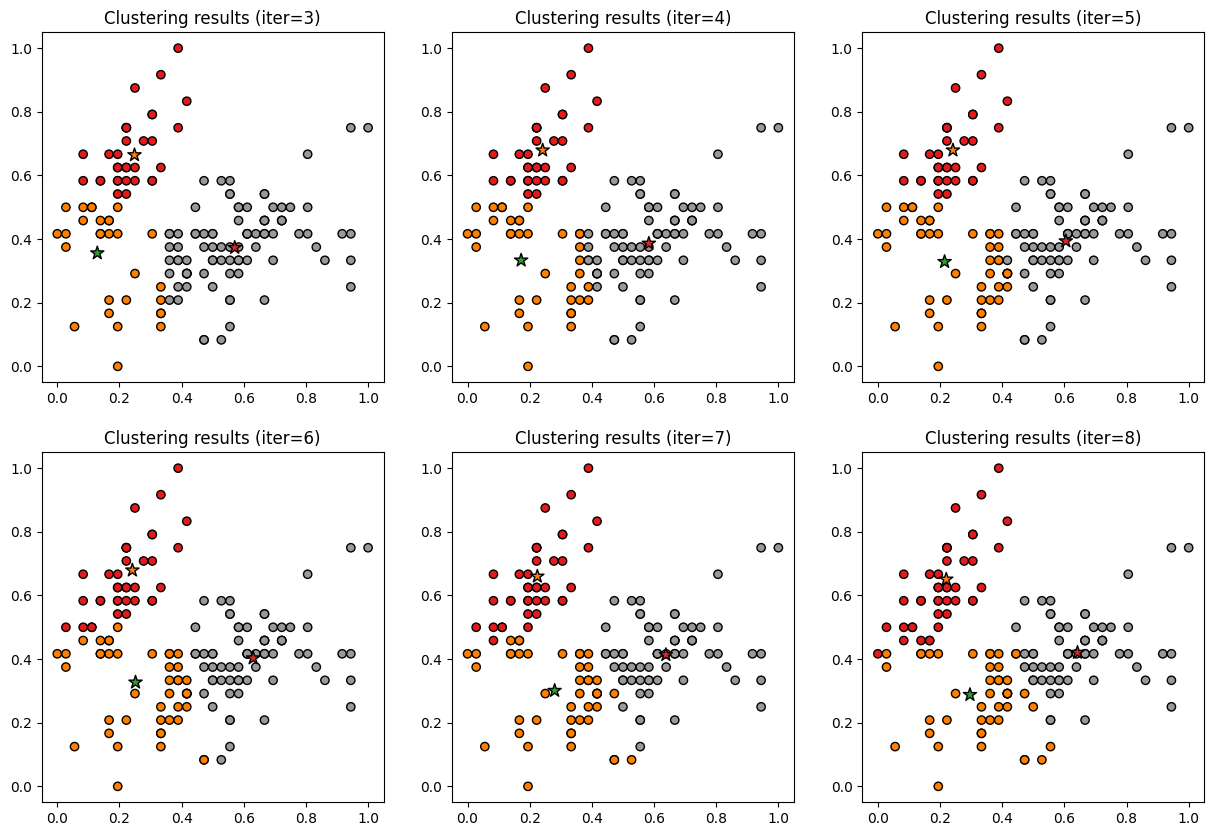

In [32]:
# step3: step2 반복: iteration 3~11
fig = plt.figure(figsize=(15, 10))
for iter in range(6):
    # 군집의 중심을 각 군집에 할당된 데이터들의 평균으로 정의 (mu_k)
    clusters = np.array(clusters)
    centroid = np.array([
        X[clusters == 0, :].mean(axis=0),
        X[clusters == 1, :].mean(axis=0),
        X[clusters == 2, :].mean(axis=0),
    ])

    # step 1 반복: 각 데이터 포인트와 군집의 중심과의 거리를 계산하여 가장 가까운 군집으로 할당 (r_ik)
    diff = X.reshape(-1, 1, 2) - centroid
    distances = np.linalg.norm(diff, 2, axis=-1)
    clusters = np.argmin(distances, axis=-1)

    # 결과 시각화
    ax = fig.add_subplot(2, 3, iter + 1)
    # 군집화된 데이터 시각화
    ax.scatter(X[:, 0], X[:, 1], c=clusters, cmap=plt.cm.Set1, edgecolor="k")
    # 군집의 중심 시각화
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='*', s=100, edgecolor="k", c=['C1','C2','C3'], label='centroid')

    ax.set_title(f'Clustering results (iter={iter + 3})')

plt.show()

위 과정 전체를 수행하는 함수를 정의하고 `plotly` 라이브러리를 활용해 시각화해보겠습니다.

In [33]:
def k_means_clustering(data, n_cluster, num_iter):
    '''
    k-means clustering 구현 및 결과값 저장
    '''
    result = {}
    # 반복횟수만큼 반복
    for iter in range(0, num_iter + 1):
        # 군집의 중심 정의
        if iter == 0:
            # 초기화: 첫번째 iteration에서는 군집의 중심을 위에서 설정한 초기 데이터로 정의 (mu_k)
            np.random.seed(0)
            init_idx = np.random.randint(data.shape[0], size=n_cluster)
            centroid = data[init_idx, :]
        else:
            # step2: 군집의 중심을 각 군집에 할당된 데이터들의 평균으로 정의 (mu_k)
            clusters = np.array(clusters)
            centroid = np.array([
                data[clusters == 0, :].mean(axis=0),
                data[clusters == 1, :].mean(axis=0),
                data[clusters == 2, :].mean(axis=0),
            ])

        # step 1: 각 데이터 포인트와 군집의 중심과의 거리를 계산하여 가장 가까운 군집으로 할당 (r_ik)
        diff = X.reshape(-1, 1, 2) - centroid
        distances = np.linalg.norm(diff, 2, axis=-1)
        clusters = np.argmin(distances, axis=-1)

        # clustering 결과를 dictionary에 iteration index 별로 저장
        result[iter] = {
            'clusters': clusters,
            'centroid': centroid,
        }
    return result

In [34]:
# iris 데이터 X에 대해 k-means clustering 수행
result = k_means_clustering(X, n_cluster=3, num_iter=10)

In [35]:
# plotly 버전
def plotly_results(data, result):

    # 데이터 전처리
    df = pd.DataFrame()
    for idx, res in result.items():

        # 각 데이터의 군집 인덱스
        cluster = pd.DataFrame(data, columns=['X','Y'])
        cluster['cluster_idx'] = res['clusters']
        cluster['iter'] = idx
        cluster['label'] = 'data'
        cluster['label_size'] = 0.1
        df = pd.concat([df, cluster], axis=0)

        # 군집 중심 데이터
        centroid = pd.DataFrame(res['centroid'], columns=['X','Y'])
        centroid.reset_index(inplace=True)
        centroid.columns = ['cluster_idx']+list(centroid.columns[1:])
        centroid['iter'] = idx
        centroid['label'] = 'cluster_centroid'
        centroid['label_size'] = 1
        df = pd.concat([df, centroid], axis=0)

    # 애니메이션 시각화
    fig = px.scatter(df, x="X", y="Y", animation_frame="iter", color="cluster_idx", size='label_size', symbol='label', width=1000, height=800, symbol_sequence= ['circle', 'star'])
    fig.update_coloraxes(showscale=False)
    fig.show()

plotly_results(X, result)

#### 📝 설명 : iteration의 종료조건

k-means 군집화는 이렇게 군집의 중심을 찾고 각 데이터를 군집에 할당하는 과정을 반복하다가, 더 이상
군집이 바뀌지 않을 때 최적의 군집이 되었다고 판단해 반복수행을 종료합니다. 위의 결과에서는 5번째 iteration 이후로 군집화 결과가 거의 바뀌지 않는 것을 확인할 수 있습니다.

이번 실습에 사용한 데이터에서는 10번 미만의 iteration만으로 군집화가 완료되어, 한 스텝씩 실행해보는
방식으로도 금방 군집화가 완료되었는지 판단할 수 있었지만,
일반적으로 좀더 복잡한 데이터에서 군집화를 수행하는 경우에는 총 수백, 수천번의 iteration 후에야 군집화가 완료되는 경우도 있어, 군집화가 완료되었는지 여부를 종료조건(terminating condition)에 따라 자동으로 판단하는 방법을 사용합니다.

일반적으로 k-means 군집화에서는, 한 스텝을 수행했을 때 군집 중심이 이전 스텝의 군집 중심의 위치로부터
움직인 거리가 미리 설정해둔 임계치보다 더 작은지 여부를 확인하는 등의 방식으로 종료조건을 설정할 수 있습니다.

### 2-2. 사이킷런을 활용한 k-means 군집화

위의 과정을 포함한 k-means clustering을 `sklearn` 라이브러리를 이용해 수행할 수 있습니다.

In [36]:
# k-means clustering 수행하기
kmeans_clustering = KMeans(n_clusters=n_cluster, n_init="auto")
kmeans_clustering.fit(X)

# k-means clustering 에 의해 정의된 군집(cluster)과 군집의 중심(centroid)
clusters = kmeans_clustering.labels_
centroid = kmeans_clustering.cluster_centers_

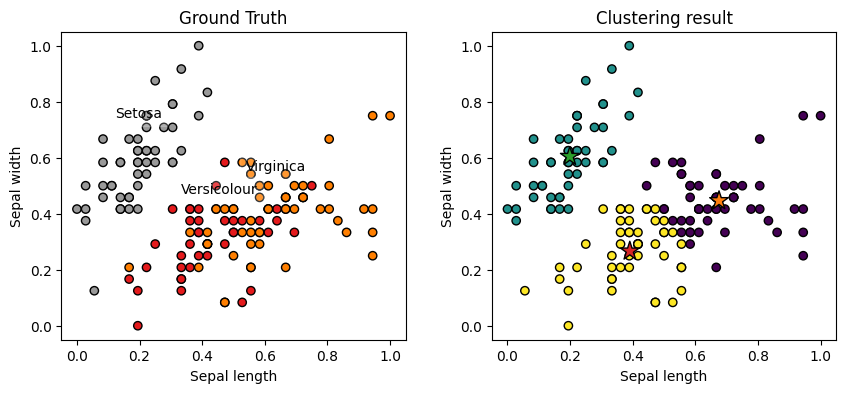

In [37]:
# 시각화
fig = plt.figure(figsize=(10, 4))

# ground truth 시각화
ax = fig.add_subplot(1, 2, 1)
for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 0.15,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [2, 0, 1]).astype(float)
ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=plt.cm.Set1)

ax.set_xlabel("Sepal length")
ax.set_ylabel("Sepal width")
ax.set_title("Ground Truth")

# clustering 결과 시각화
ax = fig.add_subplot(1, 2, 2)
# 군집화된 데이터 시각화
ax.scatter(X[:, 0], X[:, 1], c=np.array(clusters).astype(float), edgecolor="k")
# 군집의 중심 시각화
plt.scatter(centroid[:, 0], centroid[:, 1], marker='*', s=200, edgecolor="k", c=['C1','C2','C3'], label='centroid')
ax.set_xlabel("Sepal length")
ax.set_ylabel("Sepal width")
ax.set_title("Clustering result")

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

### 2-4. 랜덤 합성데이터의 군집화
> 원본 데이터에 존재하는 군집의 수와 k-means에서 지정하는 군집의 수가 변화하면서 군집화의 결과가 어떻게 달라지는지 확인해봅니다.

In [38]:
# 재현성을 위한 랜덤시드 설정
np.random.seed(123)

# 실제 데이터의 군집 수와 k-means에서 지정할 군집의 수
n_centers = 5
n_clusters = 3

# 데이터 생성
X, Y = datasets.make_blobs(n_features=2, centers=n_centers)

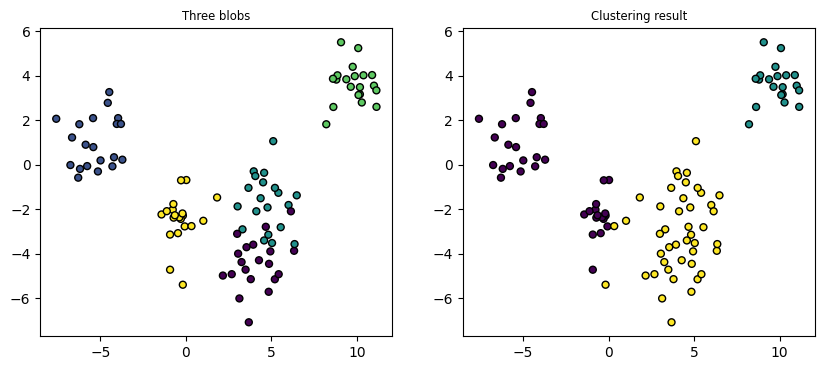

In [39]:
# 인풋 데이터와 라벨 시각화
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Three blobs", fontsize="small")
plt.scatter(X[:, 0], X[:, 1], marker="o", c=Y, s=25, edgecolor="k")

# k-means 군집화 수행
kmeans_clustering = KMeans(n_clusters=n_clusters, n_init="auto")
kmeans_clustering.fit(X)
clusters = kmeans_clustering.labels_

# 군집화 결과 시각화
plt.subplot(122)
plt.title('Clustering result', fontsize='small')
plt.scatter(X[:, 0], X[:, 1], marker="o", c=clusters, s=25, edgecolor="k")

plt.show()


#### 📝 설명: 군집 수, k의 설정

데이터에 대한 사전 지식이 거의 없을 때, 데이터를 몇 개의 군집으로 나누어야 할 지 모를 수 있습니다. 예를 들어, 고객의 구매 데이터로부터 고객의 구매 성향을 군집화할 때, 고객 군집을 몇 개로 두어야 할 지 알기 어렵습니다. 이때, __elbow method__를 사용할 수 있습니다. 각 군집의 수에 대해서 모두 군집화를 수행한 후 적절하게 $J$가 줄어든 시점을 정하는 방법입니다. 목표함수 $J$는 각 데이터와 할당된 군집의 중심까지의 거리의 제곱의 가중합으로 나타냅니다.


In [40]:
# 군집수(n_cluster)를 변화시켜가며 k-means clustering 수행
results = []
for n in range(2, 10):
    kmeans_clustering = KMeans(n_clusters=n, n_init="auto")
    kmeans_clustering.fit(X)
    results.append(kmeans_clustering.inertia_)  # inertia_: Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.

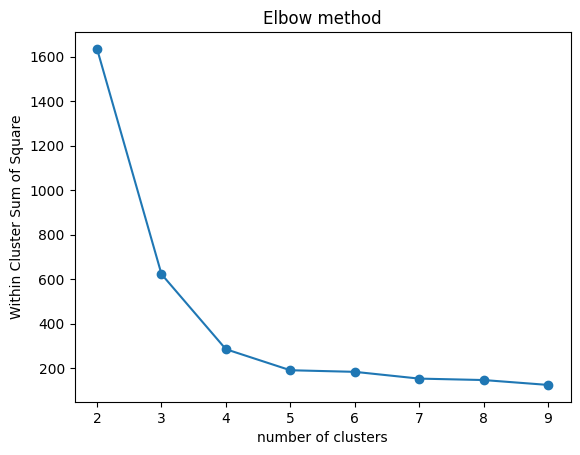

In [41]:
# 군집수(n_cluster)를 변화시켜가며 k-means clustering 을 수행한 결과의 거리 시각화
plt.plot([*range(2, 10)], results, '-o')
plt.xlabel('number of clusters')
plt.ylabel('Within Cluster Sum of Square')
plt.title('Elbow method')
plt.show()

#### 📝 설명:  k-means clustering 외의 clustering 방법

k-means clustering 알고리즘에서 평균이 아닌 다른 거리 함수나 유사도 함수를 사용하여 다른 clustering 방법을 사용할 수 있습니다. 대표적으로 k-medoids 알고리즘은 mean이 아닌 medoids로 군집의 중심을 설정하여 k-means clustering 알고리즘보다 더 robust한 성능을 보인다고 알려져 있습니다.